In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from collections import Counter
from skimage import color as scolor
from PIL import Image
from datetime import datetime
from dotenv import load_dotenv

In [2]:
load_dotenv()
folder_path = os.getenv('file_path_Munch')

In [4]:
files = os.listdir(folder_path)
target_files = []
for f in files:
    if ('.jpg' in f) or ('.jpeg' in f):
        target_files.append(os.path.join(folder_path, f))

print('Количество картин в датасете:', len(target_files))

Количество картин в датасете: 224


### Смотрим, сколько картин художник написал за каждый год жизни

In [5]:
def extract_date_from_filename(filename):
    date = filename.split('/')[-1].split('_')[0]
    return date
    
dates = []
for i in target_files:
    date = extract_date_from_filename(i)
    dates.append(date)

In [6]:
df = pd.DataFrame(dates, columns=['year'])
df.shape

(224, 1)

In [7]:
df['unknown'] = df.year.apply(lambda x: True if x == 'yyyy' else False)
df.unknown.value_counts()

unknown
False    221
True       3
Name: count, dtype: int64

In [8]:
result = df.groupby('year', as_index=False).agg({'unknown': 'count'}).rename(columns={'unknown': 'count'})

In [9]:
mask = df[df.unknown == False].year.to_list()
mask.sort()
# mask

In [10]:
mask.extend(['yyyy' for _ in range(4)])
len(mask)

225

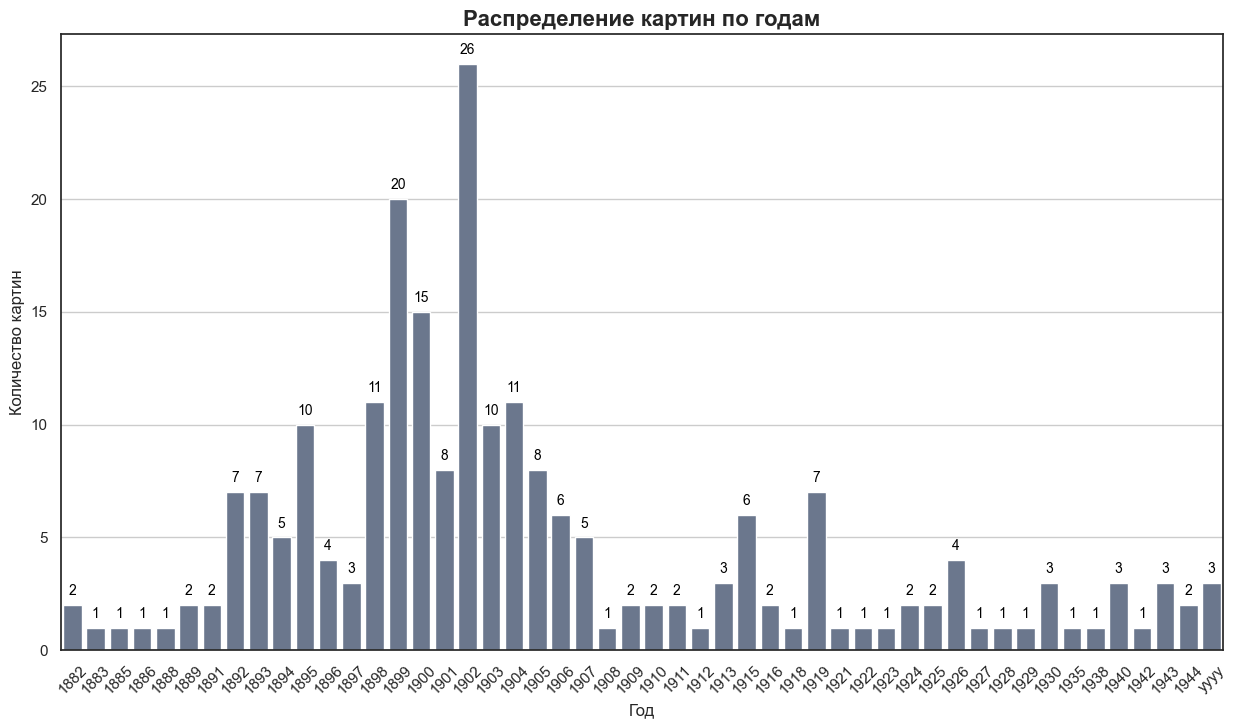

In [11]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

sns.set_theme(style="white")
plt.figure(figsize=(15, 8))

color_hex = '#{:02x}{:02x}{:02x}'.format(102, 118, 146)

bar_plot = sns.barplot(data=result, x='year', y='count', color=color_hex, order=mask)
plt.title('Распределение картин по годам', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Год', fontdict={'fontsize': 12})
plt.ylabel('Количество картин', fontdict={'fontsize': 12})
plt.xticks(rotation=45)
plt.grid(axis='y')

for p in bar_plot.patches:
    bar_plot.annotate(format(int(p.get_height())), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10, color='black', 
                        xytext=(0, 5), textcoords='offset points')

plt.show()

In [12]:
total_pixels = 0

for f in target_files:
    with Image.open(f) as img:
        img_resized = img.resize((128, 128))
        total_pixels += img_resized.width * img_resized.height
print('Всего пикселей (во всем датасете), учитывая ресайз 128х128:', total_pixels)

Всего пикселей (во всем датасете), учитывая ресайз 128х128: 3670016


### Смотрим 7 самых часто встречающихся диапазонов цветов на всех картинках

##### Без перевода из RGB в Lab с помощью KMeans:

In [13]:
def get_pixels_from_folder(folder_path):

    all_pixels = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((128, 128))
                pixels = np.array(img)
                all_pixels.append(pixels.reshape(-1, 3))

            except Exception as e:
                print(f"Can't open {filename}: {e}")

    # combine all pixels into one vector
    if all_pixels:
        rgb_vector = np.vstack(all_pixels) 
        return rgb_vector
    else:
        return np.array([])

In [14]:
# finding the n most common color ranges in the !RGB vector! and sort them by frequency
def find_most_common_colors(lab_vector, n_colors=5):
    
    if lab_vector.size == 0:
        print("Vector is empty")
        return []

    # KMeans to make clusters
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(lab_vector)

    colors = kmeans.cluster_centers_

    rgb_colors = np.clip(colors, 0, 255).astype(int)

    # counting pixels of each cluster by color
    labels = kmeans.labels_
    label_counts = Counter(labels)
    # print(label_counts)

    sorted_colors = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_rgb_colors = rgb_colors[[color[0] for color in sorted_colors]]

    return sorted_rgb_colors

In [15]:
def plot_colors(colors):
    plt.figure(figsize=(15, 6))
    plt.imshow([colors], aspect='auto')
    plt.axis('off')
    plt.show()

Семь самых распространенных цветов (RGB):
Цвет 1: [67 67 64]
Цвет 2: [32 32 33]
Цвет 3: [135  87  56]
Цвет 4: [175 166 155]
Цвет 5: [106 120 128]
Цвет 6: [190 144  82]
Цвет 7: [221 214 199]


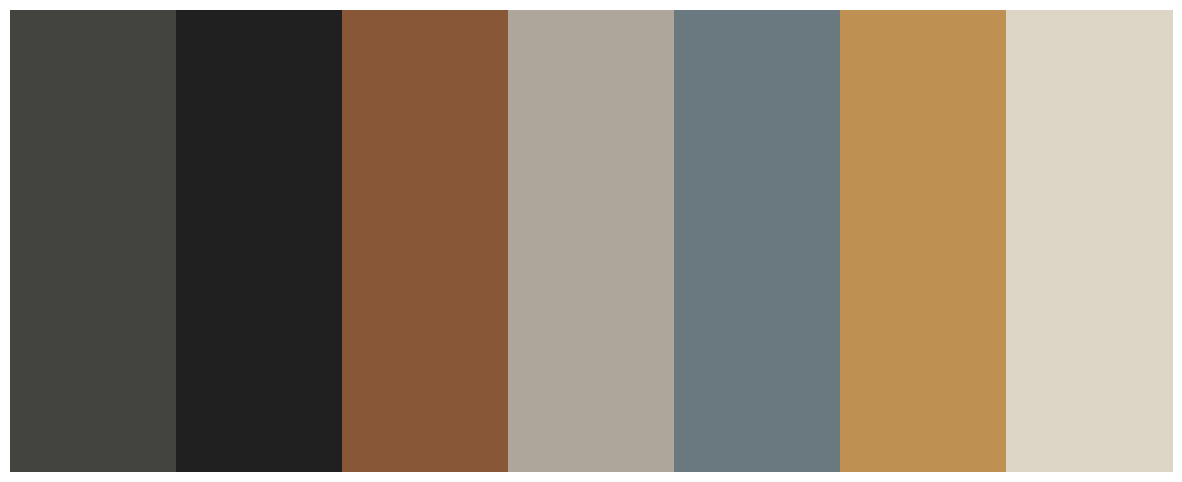

In [16]:
pixels_vector = get_pixels_from_folder(folder_path)

most_common_colors_nolab = find_most_common_colors(pixels_vector, n_colors=7)

print("Семь самых распространенных цветов (RGB):")
c = 1
for i in most_common_colors_nolab:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors_nolab)

##### С переводом из RGB в LAB с помощью KMeans:

In [17]:
def rgb_to_lab(rgb_array):

    rgb_array = rgb_array / 255.0  # normalizing RGB
    lab_array = scolor.rgb2lab(rgb_array)
    
    return lab_array

In [18]:
def get_pixels_from_folder(folder_path):

    all_pixels = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((128, 128))
                pixels = np.array(img)
                all_pixels.append(pixels.reshape(-1, 3))

            except Exception as e:
                print(f"Can't open {filename}: {e}")

    # Combine all pixels into one vector
    if all_pixels:
        rgb_vector = np.vstack(all_pixels) 
        lab_vector = rgb_to_lab(rgb_vector)
        return lab_vector
    else:
        return np.array([])

In [20]:
# finding the n most common color ranges in the !LAB vector! and sort them by frequency
def find_most_common_colors(lab_vector, n_colors=5):
    
    if lab_vector.size == 0:
        print("Vector is empty")
        return []

    # KMeans to make clusters
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(lab_vector)

    colors = kmeans.cluster_centers_

    # LAB to RGB
    rgb_colors = scolor.lab2rgb(colors.reshape(1, -1, 3)).reshape(-1, 3) * 255  # normalizing back
    rgb_colors = np.clip(rgb_colors, 0, 255).astype(int)

    # counting pixels of each cluster by color
    labels = kmeans.labels_
    label_counts = Counter(labels)

    sorted_colors = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_rgb_colors = rgb_colors[[color[0] for color in sorted_colors]]

    return sorted_rgb_colors

Семь самых распространенных цветов (RGB -> LAB -> RGB):
Цвет 1: [37 36 40]
Цвет 2: [79 74 62]
Цвет 3: [205 198 187]
Цвет 4: [145 130 104]
Цвет 5: [102 117 146]
Цвет 6: [152  79  49]
Цвет 7: [198 159  82]


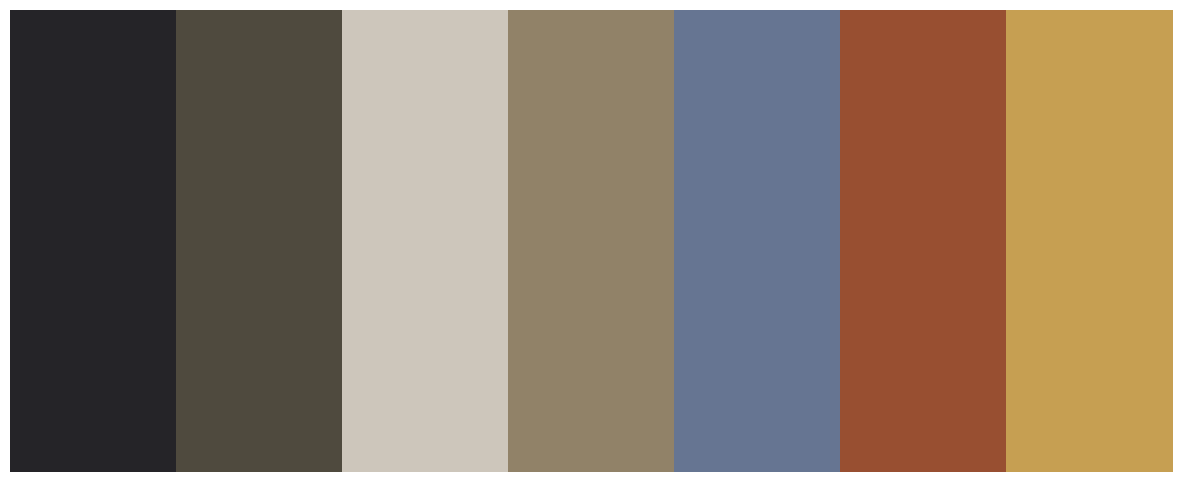

In [21]:
pixels_vector = get_pixels_from_folder(folder_path)

most_common_colors = find_most_common_colors(pixels_vector, n_colors=7)

print("Семь самых распространенных цветов (RGB -> LAB -> RGB):")
c = 1
for i in most_common_colors:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors)

##### С переводом из RGB в LAB с помощью GaussianMixture:

In [22]:
def find_most_common_colors(lab_vector, n_colors=5):
    if lab_vector.size == 0:
        print("Empty")
        return [] 

    gmm = GaussianMixture(n_components=n_colors, random_state=42)
    gmm.fit(lab_vector)

    colors = gmm.means_

    rgb_colors = scolor.lab2rgb(colors.reshape(1, -1, 3)).reshape(-1, 3) * 255  # Нормализация обратно
    rgb_colors = np.clip(rgb_colors, 0, 255).astype(int)

    # counting pixels of each cluser by color
    labels = gmm.predict(lab_vector)
    label_counts = Counter(labels)

    sorted_colors = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_rgb_colors = rgb_colors[[color[0] for color in sorted_colors]]

    return sorted_rgb_colors

Семь самых распространенных цветов (RGB):
Цвет 1: [35 37 39]
Цвет 2: [142 130 107]
Цвет 3: [73 65 56]
Цвет 4: [205 198 187]
Цвет 5: [ 85  98 120]
Цвет 6: [138  78  49]
Цвет 7: [201 163 102]


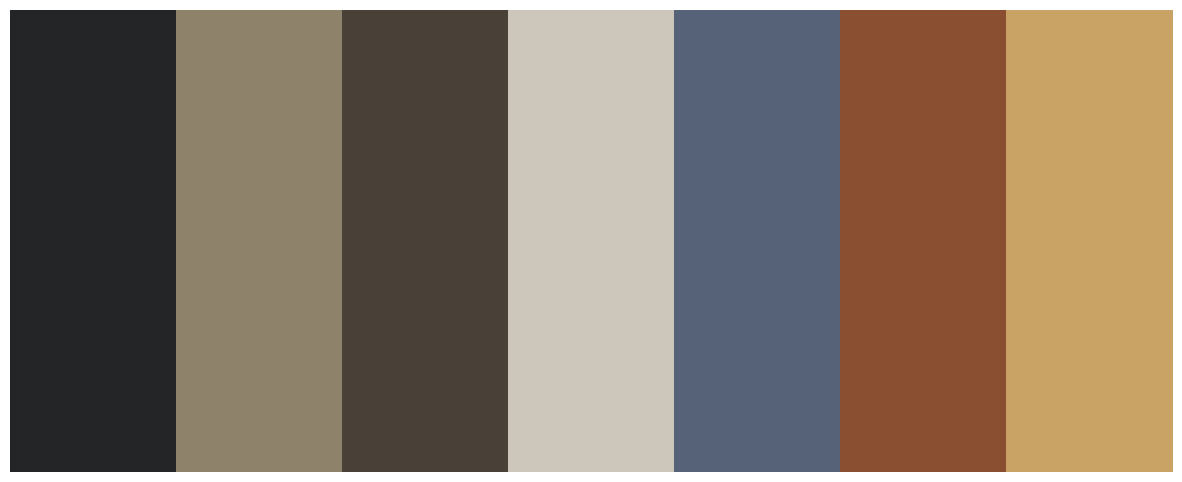

In [23]:
pixels_vector = get_pixels_from_folder(folder_path)
most_common_colors_gauss = find_most_common_colors(pixels_vector, n_colors=7)

print("Семь самых распространенных цветов (RGB):")
c = 1
for i in most_common_colors_gauss:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors_gauss)

##### С переводом из RGB в LAB с помощью BayesianGaussianMixture:

In [24]:
def find_most_common_colors(lab_vector, n_colors=5):
    if lab_vector.size == 0:
        print("Вектор пуст")
        return []

    # Используем GaussianMixture вместо KMeans
    gmm = BayesianGaussianMixture(n_components=n_colors, random_state=42)
    gmm.fit(lab_vector)

    # Центры кластеров - это средние значений компонент
    colors = gmm.means_

    # Преобразование LAB в RGB
    rgb_colors = scolor.lab2rgb(colors.reshape(1, -1, 3)).reshape(-1, 3) * 255  # Нормализация обратно
    rgb_colors = np.clip(rgb_colors, 0, 255).astype(int)

    # Подсчет пикселей каждого кластера по цвету
    labels = gmm.predict(lab_vector)
    label_counts = Counter(labels)

    sorted_colors = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_rgb_colors = rgb_colors[[color[0] for color in sorted_colors]]

    return sorted_rgb_colors

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Семь самых распространенных цветов (RGB):
Цвет 1: [51 50 49]
Цвет 2: [121 119 107]
Цвет 3: [189 163 128]
Цвет 4: [128  79  54]
Цвет 5: [215 209 198]
Цвет 6: [21 21 23]
Цвет 7: [55 73 93]


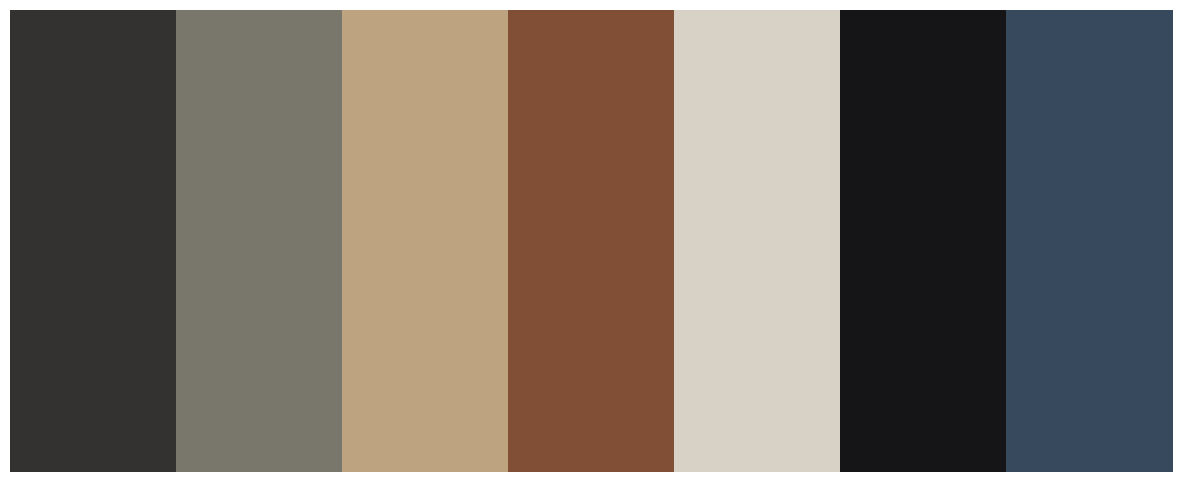

In [25]:
pixels_vector = get_pixels_from_folder(folder_path)
most_common_colors_gaussbayes = find_most_common_colors(pixels_vector, n_colors=7)

print("Семь самых распространенных цветов (RGB):")
c = 1
for i in most_common_colors_gaussbayes:
    print(f'Цвет {c}: {i}')
    c += 1

plot_colors(most_common_colors_gaussbayes)

##### С переводом из RGB в LAB с помощью DBSCAN:

In [44]:
def find_most_common_colors(lab_vector, min_samples=50, eps=5, n_colors=5):
    if lab_vector.size == 0:
        print("Вектор пуст")
        return []

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    labels = dbscan.fit_predict(lab_vector)

    # counting pixels of each cluster
    label_counts = Counter(labels)
    
    # excluding noise (label -1 in DBSCAN)
    if -1 in label_counts:
        del label_counts[-1]

    if not label_counts:
        print("DBSCAN can't find clusetrs")
        return []

    # takes n biggest clusetrs
    top_labels = [label for label, _ in label_counts.most_common(n_colors)]
    
    # counting color of each cluster
    cluster_colors = []
    for label in top_labels:
        cluster_points = lab_vector[labels == label]
        avg_color = np.mean(cluster_points, axis=0)
        cluster_colors.append(avg_color)

    cluster_colors = np.array(cluster_colors)

    rgb_colors = scolor.lab2rgb(cluster_colors.reshape(1, -1, 3)).reshape(-1, 3) * 255
    rgb_colors = np.clip(rgb_colors, 0, 255).astype(int)

    return rgb_colors

In [49]:
pixels_vector = get_pixels_from_folder(folder_path)
most_common_colors_dbscan = find_most_common_colors(pixels_vector, n_colors=5)

print("Пять самых распространенных цветов (RGB):")
for idx, color in enumerate(most_common_colors_dbscan, 1):
    print(f'Цвет {idx}: {color}')

plot_colors(most_common_colors_dbscan)

: 

### Смотрим, как часто эти цвета встречаются по годам

In [26]:
def sum_pixels_by_year(results, years):

    summed_results = {color: [] for color in results.keys()}
    unique_years = sorted(list(set(years)))

    for year in unique_years:
        indices = [i for i, y in enumerate(years) if y == year]
        for color in results.keys():
            summed_value = np.sum([results[color][i] for i in indices])
            summed_results[color].append(summed_value)

    return summed_results, unique_years

def min_max_normalization(data):
    min_val = min(data)
    max_val = max(data)
    return [(x - min_val) / (max_val - min_val) for x in data]

In [27]:
def count_pixels_in_range(image_path, color, tolerance=20):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))
    img_array = np.array(img)

    # defining the boundaries for each channel
    lower_bound = np.array(color) - tolerance
    upper_bound = np.array(color) + tolerance

    # mask for pixels falling within the range
    mask = np.all((img_array >= lower_bound) & (img_array <= upper_bound), axis=-1)

    return np.sum(mask)  # number of pixels corresponding to color

In [31]:
def extract_date_from_filename(filename):
    try:
        year, month, day = map(int, filename.split('_')[:3])
        return datetime(year, month, day)
    except (IndexError, ValueError):
        return None
    
def extract_year_from_filename(filename):
    """Извлекает год из названия файла в формате yyyy_mm_dd_i_name.jpeg"""
    try:
        year = int(filename.split('_')[0])
        return year
    except (IndexError, ValueError):
        return None 

In [28]:
# analyzing the images in the specified folder and returns the number of pixels for each color
def analyze_images(folder_path, colors):

    results = {tuple(color): [] for color in colors}
    years = []

    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            
            year = extract_year_from_filename(filename)
            if year is None:
                continue
            years.append(year)

            pixel_counts = []
            for color in colors:
                count = count_pixels_in_range(image_path, color, tolerance=20)
                pixel_counts.append(count)

            for i, color in enumerate(colors):
                results[tuple(color)].append(pixel_counts[i])

    # converting the results into a numpy array for sorting
    years = np.array(years)
    for color in results:
        results[color] = np.array(results[color])

    # sorting by year
    sorted_indices = np.argsort(years)
    years = years[sorted_indices]
    for color in results:
        results[color] = results[color][sorted_indices]

    return results, years

In [29]:
def plot_bar_distribution(results, years):
    
    results, years = sum_pixels_by_year(results, years)

    colors = list(results.keys())
    counts = np.array(list(results.values()))

    year_pixel_counts = {year: np.zeros(len(colors)) for year in years}

    # sum pixels by year
    for i, year in enumerate(years):
        for j, color in enumerate(colors):
            year_pixel_counts[year][j] += counts[j][i]

    # converting the data into an array to build a graph
    summed_counts = np.array(list(year_pixel_counts.values()))
    # pprint(summed_counts)
    summed_counts = summed_counts / summed_counts.sum(axis=1, keepdims=True)

    # convert colors to format for matplotlib (from 0 to 1)
    color_palette = [(r/255, g/255, b/255) for r, g, b in colors]

    sns.set_theme(style="white")
    plt.figure(figsize=(15, 10))

    bottom = np.zeros(len(years))
    for i, color in enumerate(colors):
        plt.bar(range(len(years)), summed_counts[:, i], bottom=bottom, color=color_palette[i], label=f'Color {color}')
        bottom += summed_counts[:, i]  # update the lower limit for accumulation

    plt.title('Распределение 7 самых часто встречающихся цветов по годам ("Эдвард Мунк")')
    plt.xlabel('Год')
    plt.ylabel('Количество пикселей (нормализованное)')
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    # plt.figtext(0.5, -0.05,
    #             'При наличии нескольких картин в один год, было взято среднее арифметическое значений по всем картинам за этот год.', 
    #             ha='center', fontsize=12)
    plt.show()

#### KMeans:

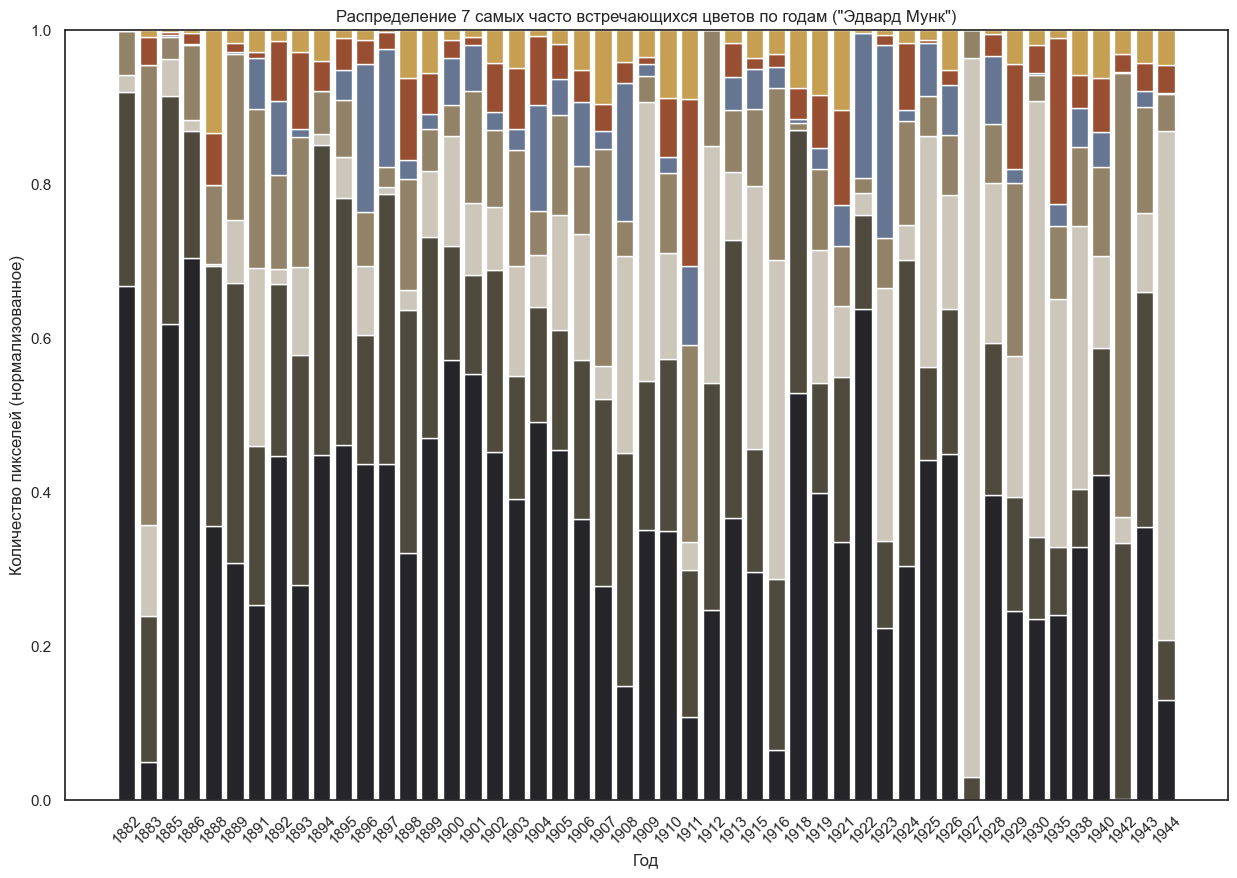

In [32]:
results, years = analyze_images(folder_path, np.array(most_common_colors))
plot_bar_distribution(results, years)

#### GaussianMixture:

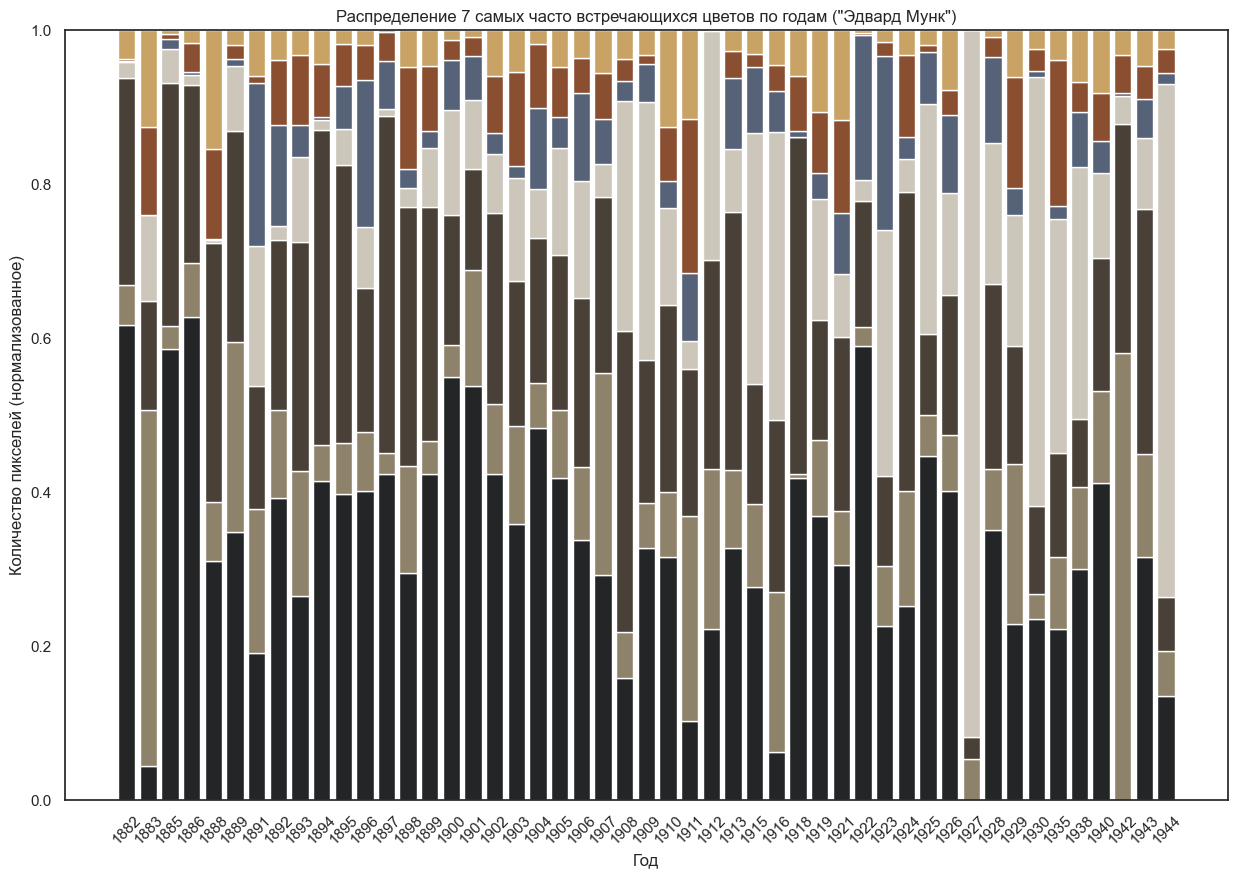

In [33]:
results, years = analyze_images(folder_path, np.array(most_common_colors_gauss))
plot_bar_distribution(results, years)

#### BayesianGaussianMixture:

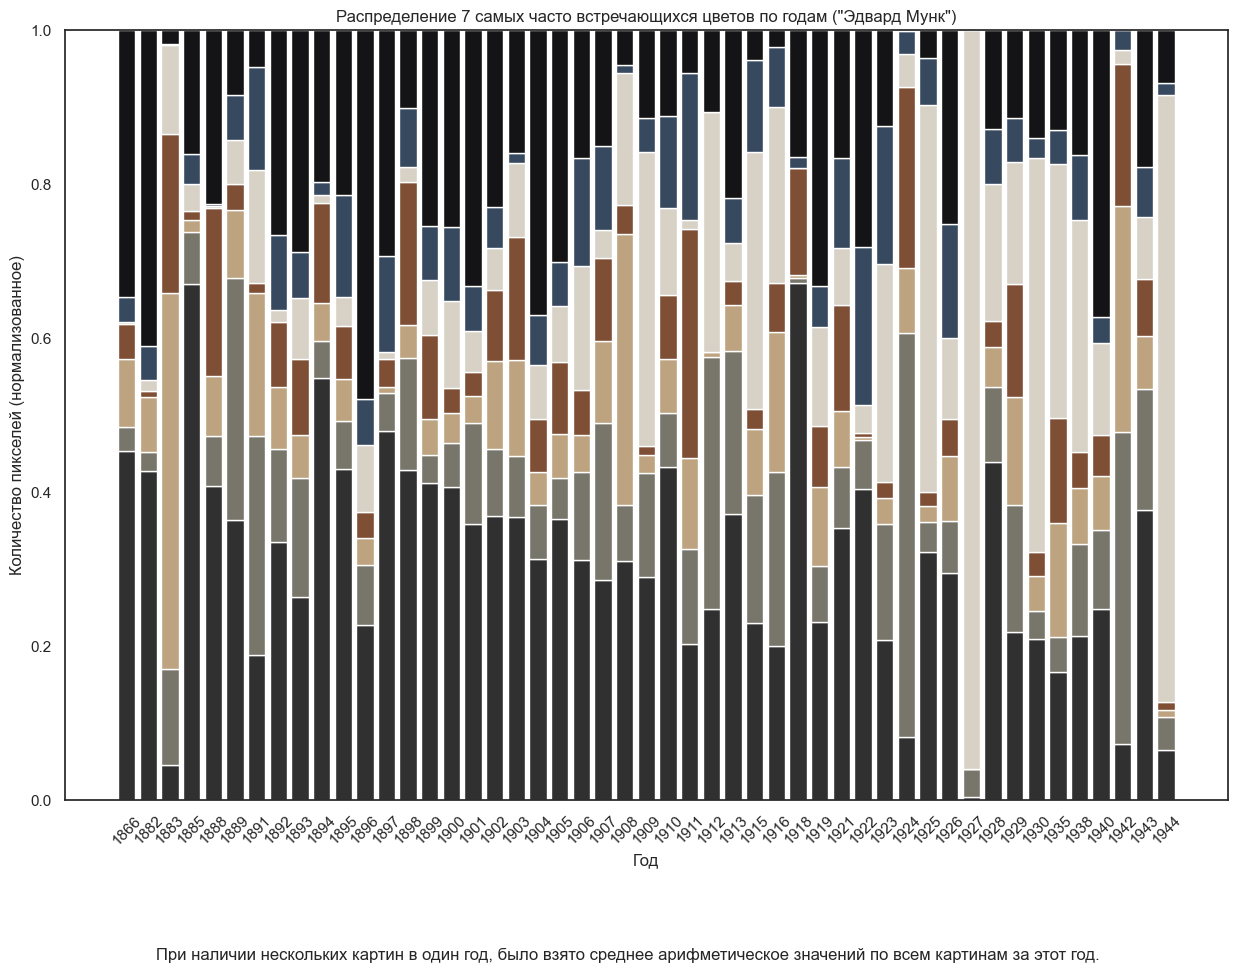

In [ ]:
results_gb, years = analyze_images(folder_path, np.array(most_common_colors_gaussbayes))
plot_bar_distribution(results_gb, years)

#### KMeans (без перевода в LAB):

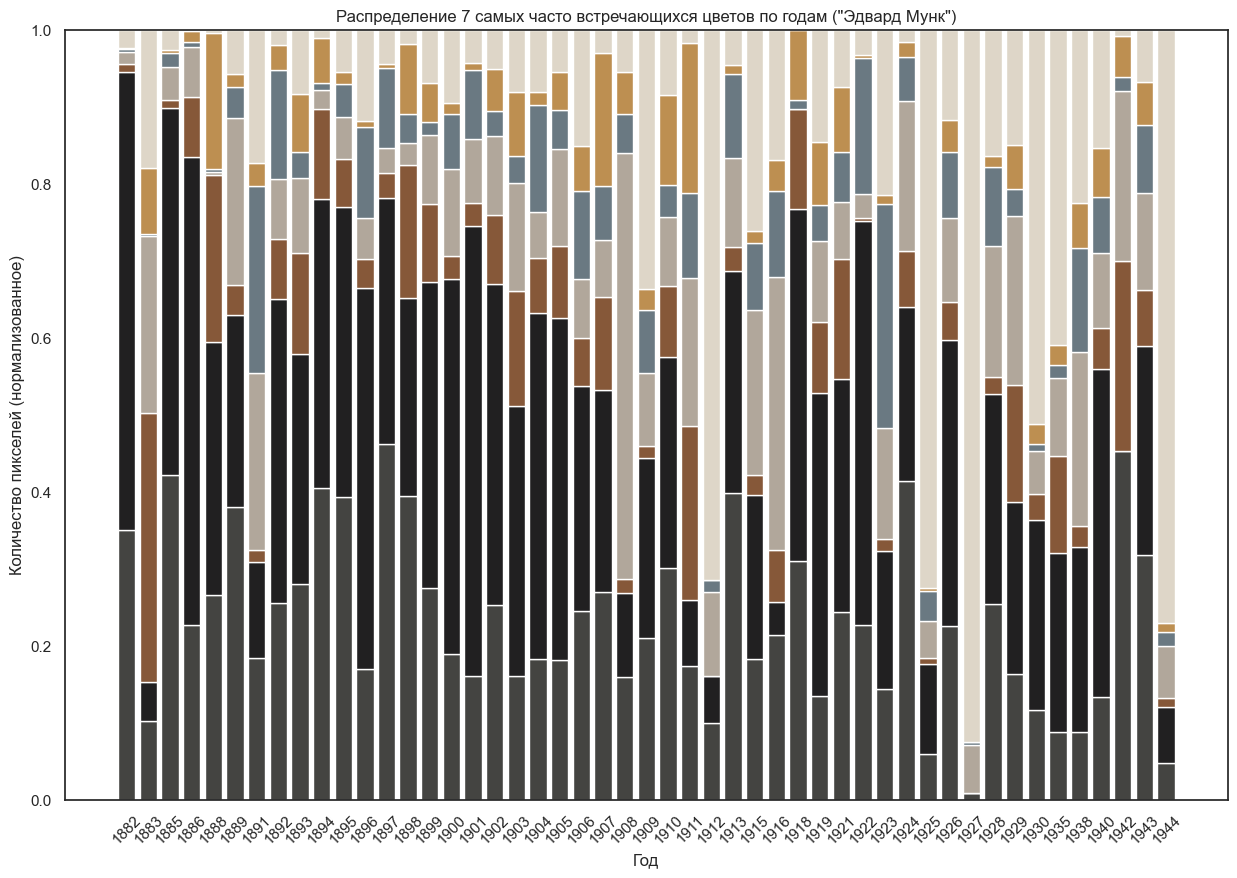

In [ ]:
results_gb, years = analyze_images(folder_path, np.array(most_common_colors_nolab))
plot_bar_distribution(results_gb, years)

### Смотрим отдельно основные цвета

In [34]:
def is_color_in_range(lab_pixel, lower_bound, upper_bound):
    return np.all((lab_pixel >= lower_bound) & (lab_pixel <= upper_bound))

def count_pixels_in_color_range(image_path, lower_bound, upper_bound):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))
    img_array = np.array(img)
    
    lab_array = rgb_to_lab(img_array.reshape(-1, 3))
    
    mask = np.apply_along_axis(is_color_in_range, 1, lab_array, lower_bound, upper_bound)
    
    return np.sum(mask)

In [35]:
def extract_year_from_filename(filename):
    try:
        return int(filename.split('_')[0])
    except (IndexError, ValueError):
        return None

In [ ]:
def analyze_images_in_range(folder_path, lower_bound, upper_bound):
    results = {}
    counts_per_year = {}
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            
            year = extract_year_from_filename(filename)
            if year is None:
                continue
            
            count = count_pixels_in_color_range(image_path, lower_bound, upper_bound)
            
            if year in results:
                results[year] += count
                counts_per_year[year] += 1
            else:
                results[year] = count
                counts_per_year[year] = 1
    
    years = np.array(list(results.keys()))
    # total_counts = np.array([results[year] / counts_per_year[year] for year in years])
    total_counts = np.array([results[year] / total_pixels for year in years]) # normalizing by all pixels in dataset (with resize to 128x128)
    
    sorted_indices = np.argsort(years)
    years = years[sorted_indices]
    total_counts = total_counts[sorted_indices]
    
    return total_counts, years

In [37]:
def plot_color_distribution(results, years, color_name, color_hex):
    sns.set_theme(style="white")
    plt.figure(figsize=(15, 10))
    plt.bar(range(len(years)), results, color=color_hex, label=f'{color_name} диапазон')
    plt.title(f'Распределение цвета ({color_name}) по годам')
    plt.xlabel('Год')
    plt.ylabel('Среднее количество пикселей на картину')
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    plt.legend(loc='upper left')
    plt.show()


#### Красный:

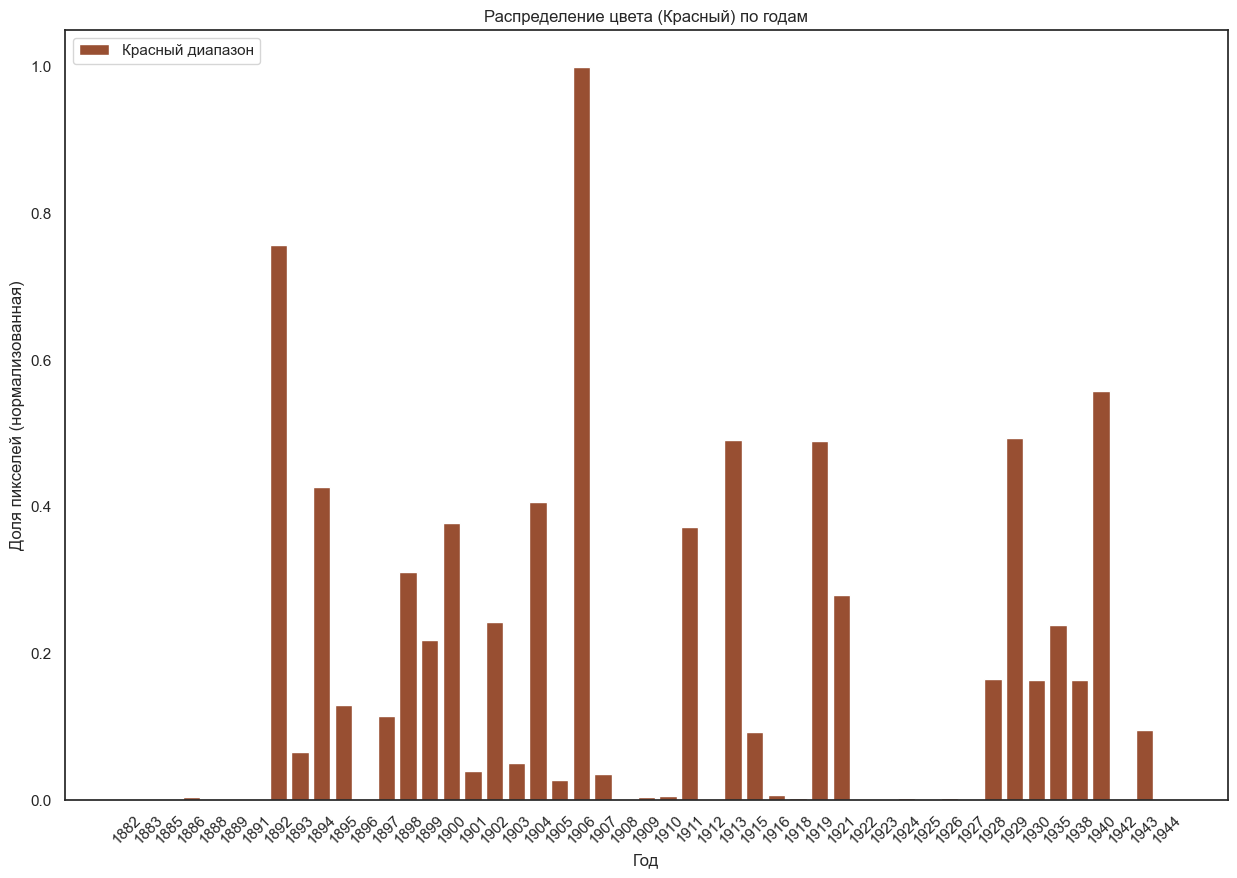

In [42]:
lower_bound = np.array([20, 40, 20])
upper_bound = np.array([80, 100, 80])

results, years = analyze_images_in_range(folder_path, lower_bound, upper_bound)

color_hex = '#{:02x}{:02x}{:02x}'.format(152, 79, 50)

plot_color_distribution(results, years, color_name="Красный", color_hex=color_hex)

#### Зеленый:

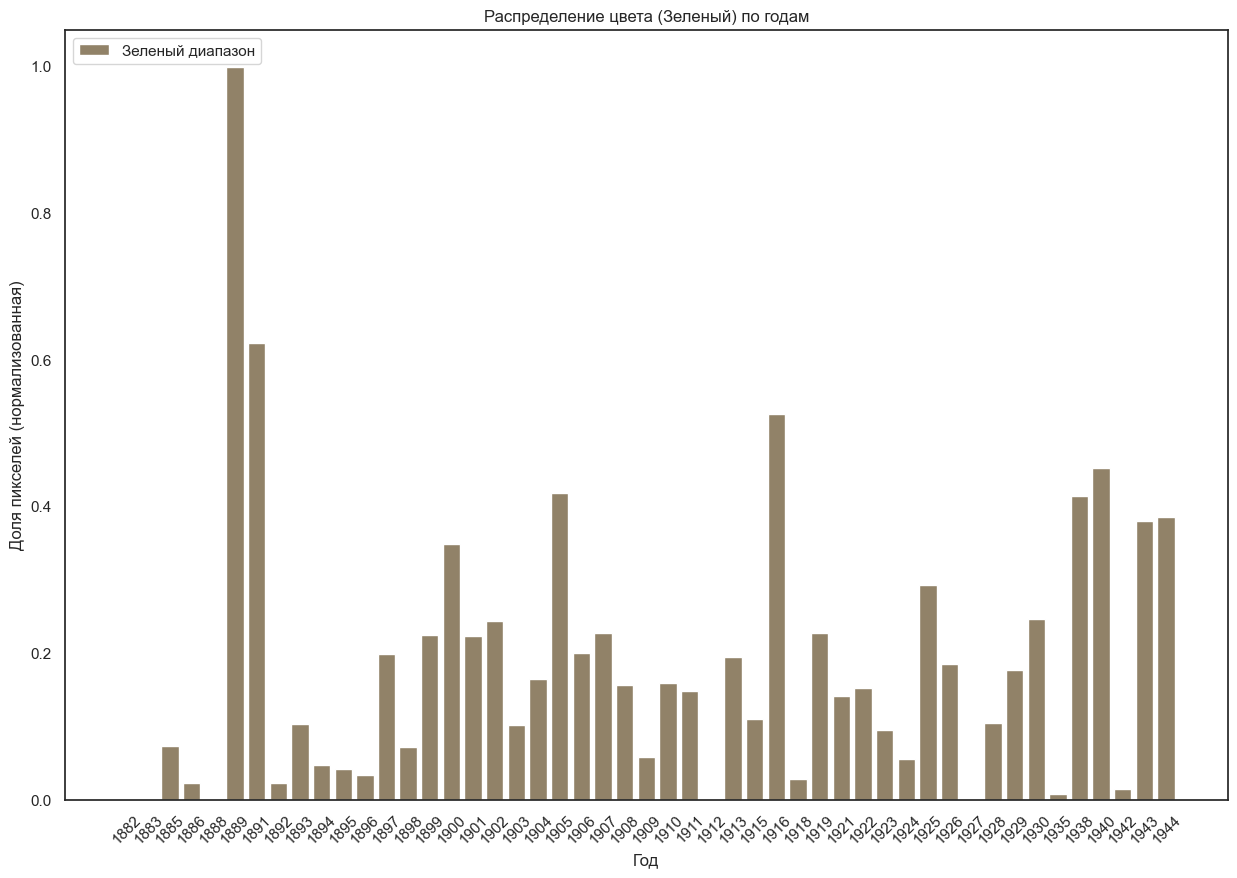

In [41]:
lower_bound_green = np.array([20, -128, -20])  
upper_bound_green = np.array([80, -10, 50])

results, years = analyze_images_in_range(folder_path, lower_bound_green, upper_bound_green)

color_hex = '#{:02x}{:02x}{:02x}'.format(145, 130, 104)

plot_color_distribution(results, years, color_name="Зеленый", color_hex=color_hex)

#### Синий:

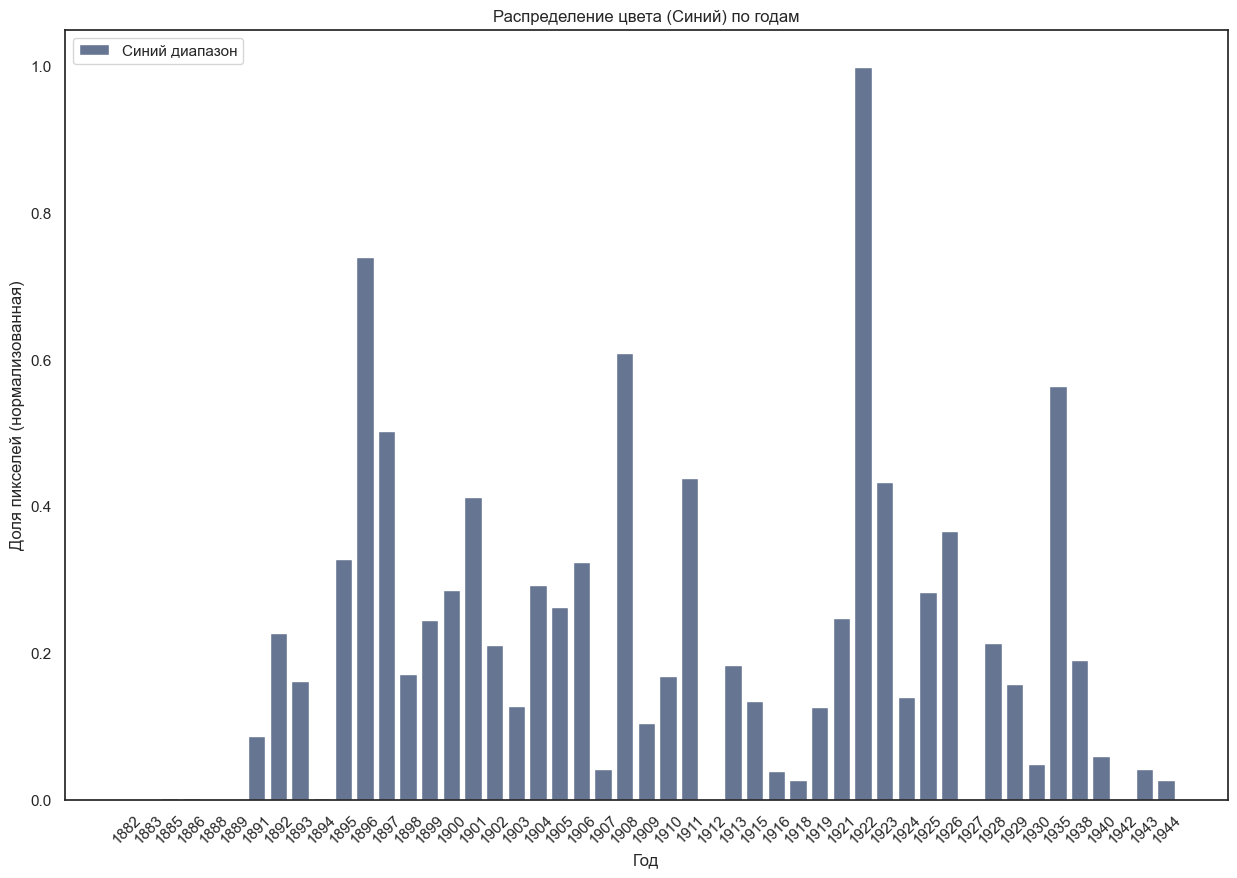

In [43]:
lower_bound_blue = np.array([20, -50, -128])  
upper_bound_blue = np.array([70, 50, -10])
    
color_hex = '#{:02x}{:02x}{:02x}'.format(102, 118, 146)

results, years = analyze_images_in_range(folder_path, lower_bound_blue, upper_bound_blue)

plot_color_distribution(results, years, color_name="Синий", color_hex=color_hex)

#### Желтый:

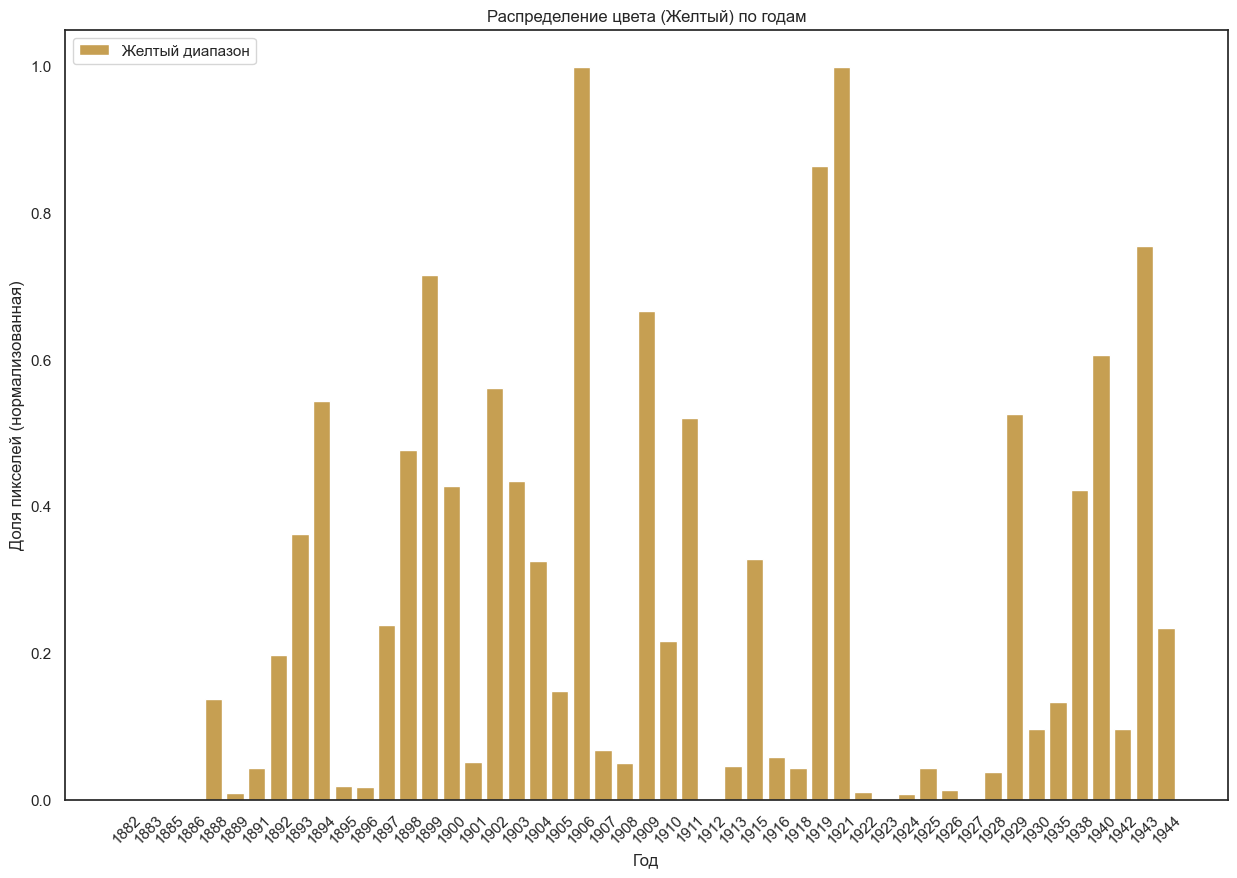

In [44]:
lower_bound_yellow = np.array([50, 0, 50])  
upper_bound_yellow = np.array([100, 80, 128])
    
color_hex = '#{:02x}{:02x}{:02x}'.format(198, 159, 82)

results, years = analyze_images_in_range(folder_path, lower_bound_yellow, upper_bound_yellow)

plot_color_distribution(results, years, color_name="Желтый", color_hex=color_hex)

### Смотрим 7 самых часто используемых цветов за каждый год

#### Counter:

In [45]:
def get_most_common_colors(image_path, num_colors=5, resize_dim=(128, 128), rounding=10):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(resize_dim)
    pixels = np.array(image).reshape(-1, 3)
    pixels = rgb_to_lab(pixels)

    pixels = (pixels // rounding) * rounding
    
    color_counter = Counter(map(tuple, pixels))
    most_common = color_counter.most_common(num_colors)
    
    return most_common  # colors and amounts

In [ ]:
def get_colors_by_year(images_folder):
    
    colors_by_year = {}
    
    for file in os.listdir(images_folder):
        if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
            try:
                year = file.split('_')[0]
                year = int(year)
            except ValueError:
                continue
            
            image_path = os.path.join(images_folder, file)
            common_colors = get_most_common_colors(image_path)
            
            if year not in colors_by_year:
                colors_by_year[year] = []
            
            # add color codes and pixel counts
            for color, count in common_colors:
                colors_by_year[year].append((color, count))
    
    # top-7 by each year
    top_colors_by_year = {}
    for year, colors in colors_by_year.items():
        color_counter = Counter(dict(colors)) # count the number of pixels for each color
        top_colors = color_counter.most_common(7)
        top_colors_by_year[year] = {color: count for color, count in top_colors}
    
    return top_colors_by_year

In [47]:
def plot_color_distribution(colors_by_year):

    years = [year for year in sorted(colors_by_year.keys()) if colors_by_year[year]] # filter the years for which there is data
    
    # all colors
    all_colors = set()
    for color_dict in colors_by_year.values():
        all_colors.update(color_dict.keys())
    all_colors = list(all_colors)
    
    data = {color: [] for color in all_colors}
    
    # Normalize data on the Y axis (0 to 1) for each year
    for year in years:
        year_data = colors_by_year.get(year, {})
        total_pixels = sum(year_data.values())  # sum of all pixels for one year
        if total_pixels == 0: 
            total_pixels = 1
        for color in all_colors:
            count = year_data.get(color, 0)
            normalized_count = count / total_pixels  # normalizing
            data[color].append(normalized_count)
    
    bottom = np.zeros(len(years))
    plt.figure(figsize=(15, 8))
    
    for color in all_colors:
        # Converting from LAB to RGB for display on a graph
        lab_color = np.array(color).reshape(1, 1, 3)
        rgb_color = scolor.lab2rgb(lab_color).reshape(3) 
        rgb_color = np.clip(rgb_color, 0, 1)
        
        plt.bar(range(len(years)), data[color], bottom=bottom, color=rgb_color, label=str(color))
        bottom += np.array(data[color])
    
    plt.xlabel('Год')
    plt.ylabel('Нормализованное количество пикселей')
    plt.title('Частота использования топ-5 цветов на картинах по годам (нормализовано)')
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    plt.show()

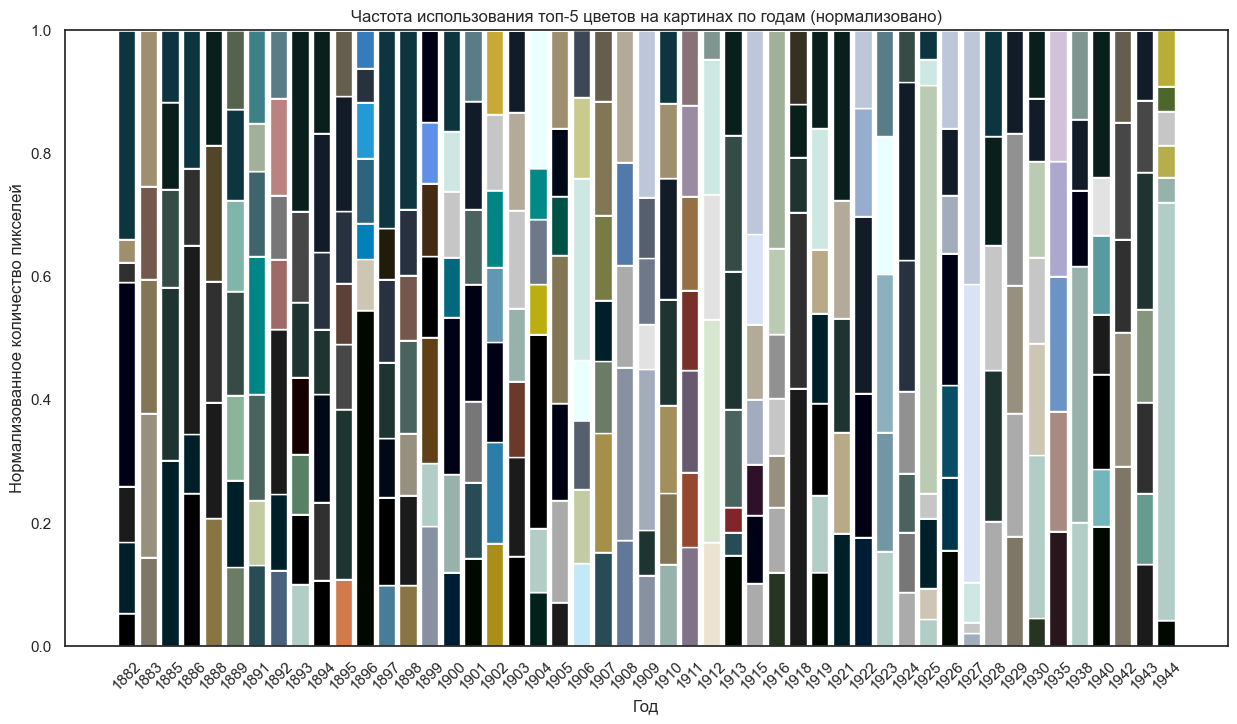

In [48]:
colors_by_year = get_colors_by_year(folder_path)
plot_color_distribution(colors_by_year)

#### GaussianMixture:

In [49]:
def rgb_to_lab(rgb_pixels):
    rgb_pixels = rgb_pixels / 255.0
    lab_pixels = scolor.rgb2lab(rgb_pixels.reshape(-1, 1, 3)).reshape(-1, 3)
    return lab_pixels

def lab_to_rgb(lab_color):
    lab_color = np.array(lab_color).reshape(1, 1, 3)
    rgb_color = scolor.lab2rgb(lab_color).reshape(3) * 255
    rgb_color = np.clip(rgb_color, 0, 255).astype(int)
    return tuple(rgb_color)

In [50]:
def get_most_common_colors(image_path, num_colors=5, resize_dim=(100, 100)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(resize_dim)
    pixels = np.array(image).reshape(-1, 3)
    pixels = rgb_to_lab(pixels)

    gmm = GaussianMixture(n_components=num_colors, random_state=42)
    gmm.fit(pixels)
    labels = gmm.predict(pixels)
    cluster_centers = gmm.means_
    
    color_counter = Counter(labels)
    most_common = color_counter.most_common(num_colors)
    
    rgb_colors = []
    for cluster_idx, count in most_common:
        lab_color = cluster_centers[cluster_idx]
        rgb_color = lab_to_rgb(lab_color)
        rgb_colors.append((rgb_color, count))
    
    return rgb_colors

In [ ]:
# def get_colors_by_year(images_folder):
#     colors_by_year = {}
    
#     for file in os.listdir(images_folder):
#         if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
#             try:
#                 year = file.split('_')[0]
#                 year = int(year)
#             except ValueError:
#                 continue
            
#             image_path = os.path.join(images_folder, file)
#             common_colors = get_most_common_colors(image_path)
            
#             if year not in colors_by_year:
#                 colors_by_year[year] = []
            
#             for color, count in common_colors:
#                 colors_by_year[year].append((color, count))
    
#     top_colors_by_year = {}
#     for year, colors in colors_by_year.items():
#         color_counter = Counter(dict(colors))  # Подсчитываем количество пикселей для каждого цвета
#         top_colors = color_counter.most_common(5)  # Получаем топ-5
#         top_colors_by_year[year] = {color: count for color, count in top_colors}
    
#     return top_colors_by_year

In [ ]:
def plot_color_distribution(colors_by_year):

    years = [year for year in sorted(colors_by_year.keys()) if colors_by_year[year]]
    
    all_colors = set()
    for color_dict in colors_by_year.values():
        all_colors.update(color_dict.keys())
    all_colors = list(all_colors)
    
    data = {color: [] for color in all_colors}
    
    for year in years:
        year_data = colors_by_year.get(year, {})
        total_pixels = sum(year_data.values())
        if total_pixels == 0: 
            total_pixels = 1
        for color in all_colors:
            count = year_data.get(color, 0)
            normalized_count = count / total_pixels 
            data[color].append(normalized_count)
    
    bottom = np.zeros(len(years))
    plt.figure(figsize=(15, 8))
    
    for color in all_colors:
        plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
        bottom += np.array(data[color])
    
    plt.xlabel('Год')
    plt.ylabel('Нормализованное количество пикселей')
    plt.title('Частота использования топ-5 цветов на картинах по годам (нормализовано)')
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    plt.show()

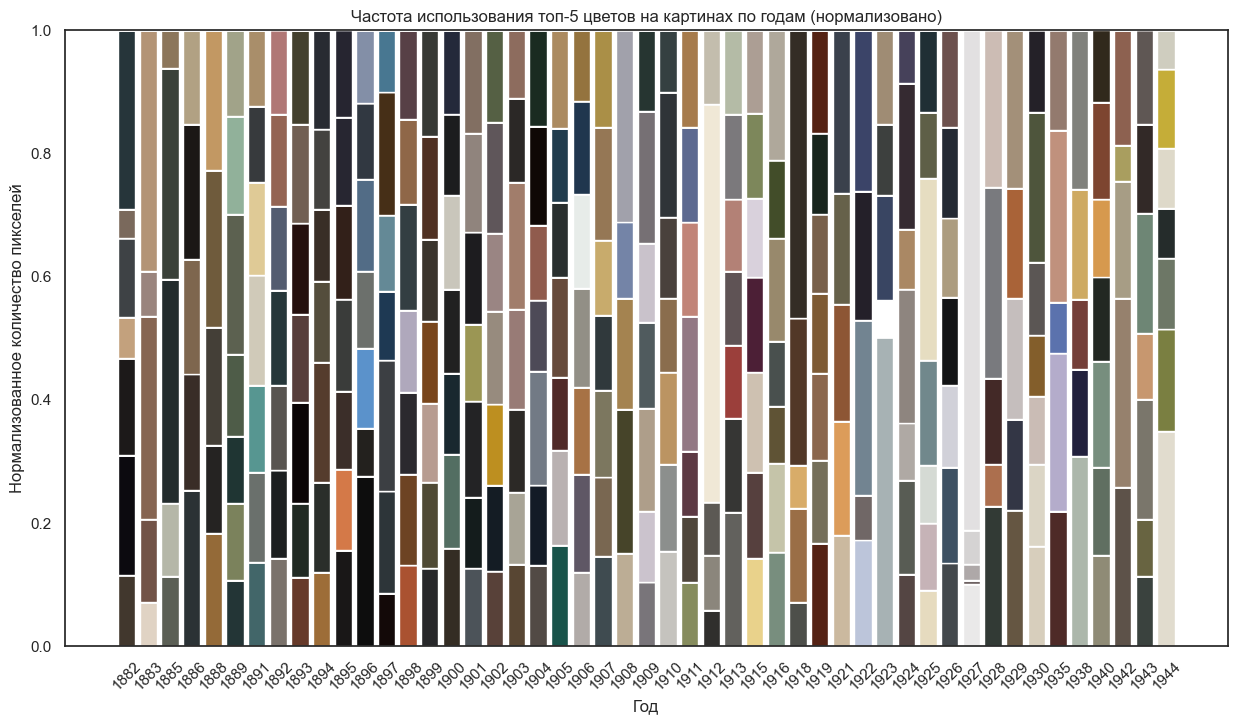

In [ ]:
colors_by_year_gm = get_colors_by_year(folder_path)
plot_color_distribution(colors_by_year_gm)

#### KMeans:

In [ ]:
def get_most_common_colors(image_path, num_colors=5, resize_dim=(100, 100)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(resize_dim)
    pixels = np.array(image).reshape(-1, 3)
    pixels = rgb_to_lab(pixels)

    kmeans = KMeans(n_clusters=num_colors, random_state=42)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    
    color_counter = Counter(labels)
    most_common = color_counter.most_common(num_colors)
    
    rgb_colors = []
    for cluster_idx, count in most_common:
        lab_color = cluster_centers[cluster_idx]
        rgb_color = lab_to_rgb(lab_color)
        rgb_colors.append((rgb_color, count))
    
    return rgb_colors

In [ ]:
def plot_color_distribution(colors_by_year):

    years = [year for year in sorted(colors_by_year.keys()) if colors_by_year[year]]
    
    all_colors = set()
    for color_dict in colors_by_year.values():
        all_colors.update(color_dict.keys())
    all_colors = list(all_colors)
    
    data = {color: [] for color in all_colors}
    
    for year in years:
        year_data = colors_by_year.get(year, {})
        total_pixels = sum(year_data.values())
        if total_pixels == 0:
            total_pixels = 1
        for color in all_colors:
            count = year_data.get(color, 0)
            normalized_count = count / total_pixels
            data[color].append(normalized_count)
    
    bottom = np.zeros(len(years))
    plt.figure(figsize=(15, 8))
    
    for color in all_colors:
        plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
        bottom += np.array(data[color])
    
    plt.xlabel('Год')
    plt.ylabel('Нормализованное количество пикселей')
    plt.title('Частота использования топ-5 цветов на картинах по годам (нормализовано)')
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    plt.show()

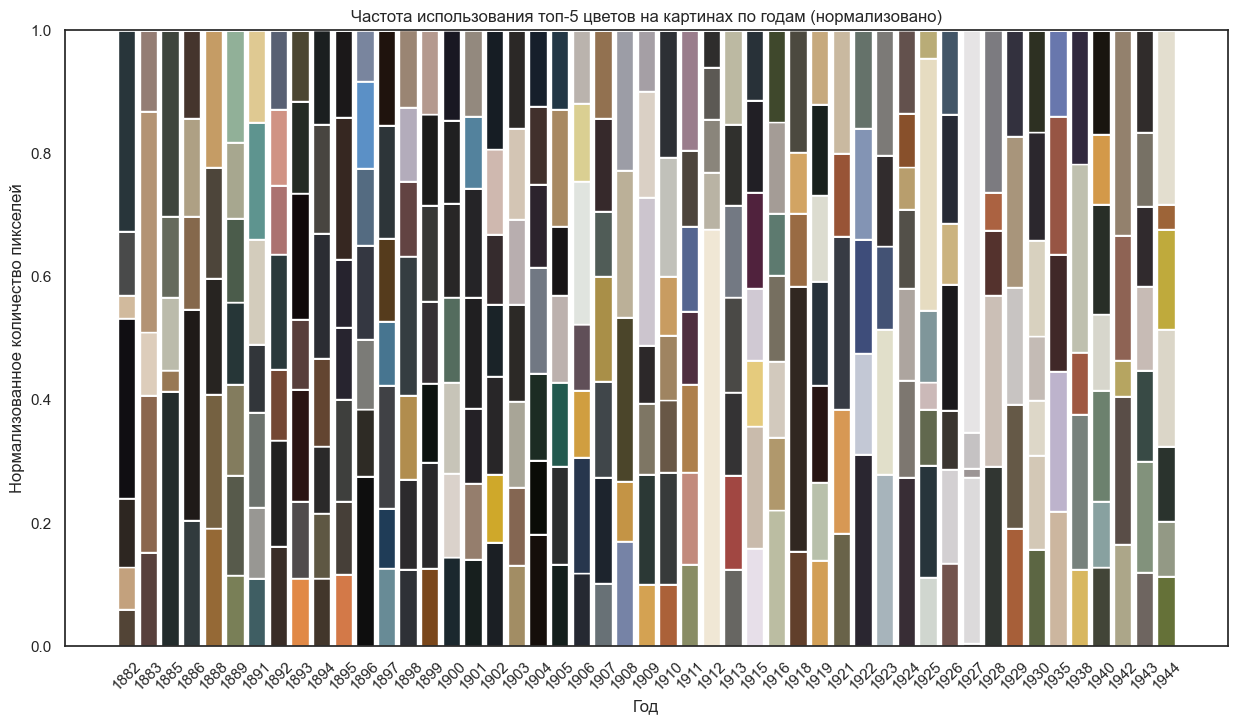

In [57]:
colors_by_year_km = get_colors_by_year(folder_path)
plot_color_distribution(colors_by_year_km)

#### BayesianGaussianMixture:

In [ ]:
def get_most_common_colors(image_path, num_colors=5, resize_dim=(100, 100)):
    image = Image.open(image_path).convert('RGB')
    image = image.resize(resize_dim)
    pixels = np.array(image).reshape(-1, 3)
    pixels = rgb_to_lab(pixels)

    gmm = BayesianGaussianMixture(n_components=num_colors, random_state=42)
    gmm.fit(pixels)
    labels = gmm.predict(pixels)
    cluster_centers = gmm.means_
    
    color_counter = Counter(labels)
    most_common = color_counter.most_common(num_colors)
    
    rgb_colors = []
    for cluster_idx, count in most_common:
        lab_color = cluster_centers[cluster_idx]
        rgb_color = lab_to_rgb(lab_color)
        rgb_colors.append((rgb_color, count))
    
    return rgb_colors 

In [59]:
def plot_color_distribution(colors_by_year):

    years = [year for year in sorted(colors_by_year.keys()) if colors_by_year[year]]
    
    all_colors = set()
    for color_dict in colors_by_year.values():
        all_colors.update(color_dict.keys())
    all_colors = list(all_colors)
    
    data = {color: [] for color in all_colors}

    for year in years:
        year_data = colors_by_year.get(year, {})
        total_pixels = sum(year_data.values())
        if total_pixels == 0:
            total_pixels = 1
        for color in all_colors:
            count = year_data.get(color, 0)
            normalized_count = count / total_pixels
            data[color].append(normalized_count)
    
    bottom = np.zeros(len(years))
    plt.figure(figsize=(15, 8))
    
    for color in all_colors:
        plt.bar(range(len(years)), data[color], bottom=bottom, color=np.array(color)/255.0, label=str(color))
        bottom += np.array(data[color])
    
    plt.xlabel('Год')
    plt.ylabel('Нормализованное количество пикселей')
    plt.title('Частота использования топ-5 цветов на картинах по годам (нормализовано)')
    plt.xticks(ticks=range(len(years)), labels=years, rotation=45)
    # plt.legend(title='Цвета (RGB)', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initializa

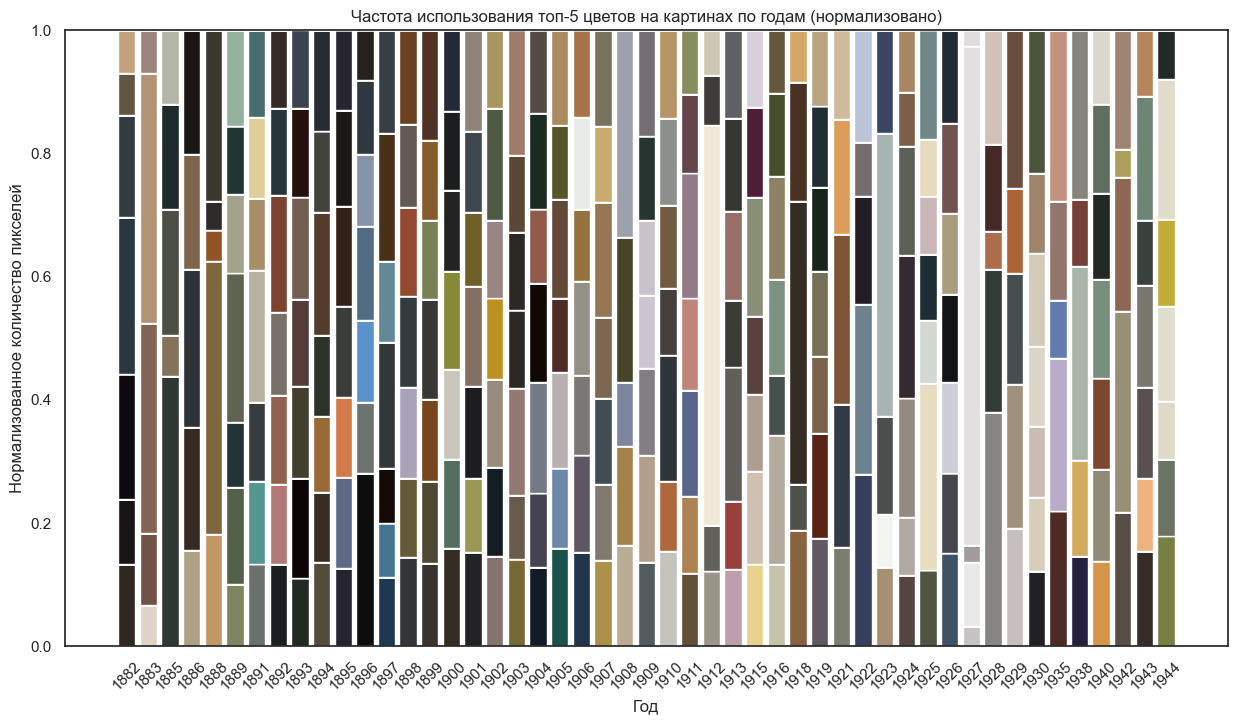

In [60]:
colors_by_year_bgm = get_colors_by_year(folder_path)
plot_color_distribution(colors_by_year_bgm)